This example conducts walks through plotting of GHI and WPD errors from the optwrf database.

Last Updated by Jeffrey Sward on Sept 30, 2020.

In [3]:
import csv
import datetime
import math
import random
import sys
import time

import shap
import seaborn as sns
import pandas as pd
# import prince
import numpy as np
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from optwrf.wrfparams import num2name
from optwrf.helper_functions import date2season

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

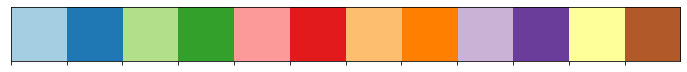

In [4]:
cmap1 = sns.color_palette('Paired', 12)
sns.palplot(cmap1)

In [13]:
# Read in the optwrf csv data file 
dateparse = lambda x: pd.datetime.strptime(x, '%b %d %Y')
data = pd.read_csv('./optwrf_database_090820.csv', parse_dates=['start_date'], date_parser=dateparse)
# Replace missing data with NaN values
data['fitness'].values[data['fitness'] > 1 * 10 ** 23] = np.nan
data['ghi_error'].values[data['ghi_error'] > 1 * 10 ** 23] = np.nan
data['wpd_error'].values[data['wpd_error'] > 1 * 10 ** 23] = np.nan
# Determine the season
data['season'] = [date2season(dat) for dat in data.start_date]
data.iloc[:5,:]

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


,start_date,mp_physics,ra_lw_physics,ra_sw_physics,sf_surface_physics,bl_pbl_physics,cu_physics,sf_sfclay_physics,fitness,ghi_error,wpd_error,runtime,season
0,2011-11-10,2,5,99,2,4,16,4,31298.680307,10831.90,56780220.0,03h 23m 16s,fall
1,2011-11-25,51,1,7,1,11,1,1,31516.466190,21342.01,41989356.0,00h 51m 09s,fall
2,2011-10-07,13,3,3,7,12,10,1,19734.008641,8762.55,30784876.0,01h 05m 24s,fall
3,2011-08-13,17,3,2,4,12,16,1,24613.299895,20582.19,13254863.0,01h 51m 31s,summer
4,2011-04-02,3,31,7,7,2,6,2,71681.216361,52733.16,64502156.0,00h 46m 48s,spring


## Plots of each physics paramerization option vs. fitness

In [14]:
# Sort data by start_date to make the plots look cleaner
data = data.sort_values(by='start_date')
data

,start_date,mp_physics,ra_lw_physics,ra_sw_physics,sf_surface_physics,bl_pbl_physics,cu_physics,sf_sfclay_physics,fitness,ghi_error,wpd_error,runtime,season
61,2011-01-01,1,99,3,7,6,14,5,NaN,NaN,NaN,00h 00m 10s,winter
181,2011-01-01,14,5,99,3,9,7,10,NaN,NaN,NaN,00h 00m 00s,winter
369,2011-01-02,17,3,3,1,12,10,1,18528.185792,6116.20,34859796.0,05h 57m 36s,winter
538,2011-01-02,10,99,3,4,8,5,1,13410.827553,6102.80,22748338.0,03h 10m 57s,winter
247,2011-01-04,51,7,5,5,1,11,1,17505.454709,8353.89,29085720.0,04h 36m 25s,winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,2011-12-27,18,99,99,4,4,3,4,22693.656017,7558.65,42659808.0,02h 12m 38s,winter
288,2011-12-28,3,1,4,5,8,94,1,33210.576110,6774.69,68740776.0,05h 12m 15s,winter
92,2011-12-28,15,24,1,3,1,11,1,NaN,NaN,NaN,00h 00m 00s,winter
168,2011-12-29,51,3,5,5,1,11,1,24437.208104,7868.41,46321636.0,05h 47m 36s,winter


In [10]:
def format_plot(xlab='xlabel', ylab='ylabel'):
    # find and format dates
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    date_fmt = mdates.DateFormatter('%b')

    # format the ticks
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(date_fmt)
    ax.xaxis.label.set_fontsize(14)
    ax.yaxis.label.set_fontsize(14)

    # round to nearest month
    datemin = np.datetime64(data['start_date'].iloc[0], 'm')
    datemax = np.datetime64(data['start_date'].iloc[-1], 'm') + np.timedelta64(1, 'm')
    ax.set_xlim(datemin, datemax)

    # format the coords message box
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax.grid(True)

    # rotates and right aligns the x labels, and moves the bottom of the
    # axes up to make room for them
    fig.autofmt_xdate()
    
    # format x and y labels
    plt.xlabel(xlab, fontsize=18)
    plt.ylabel(ylab, fontsize=18)

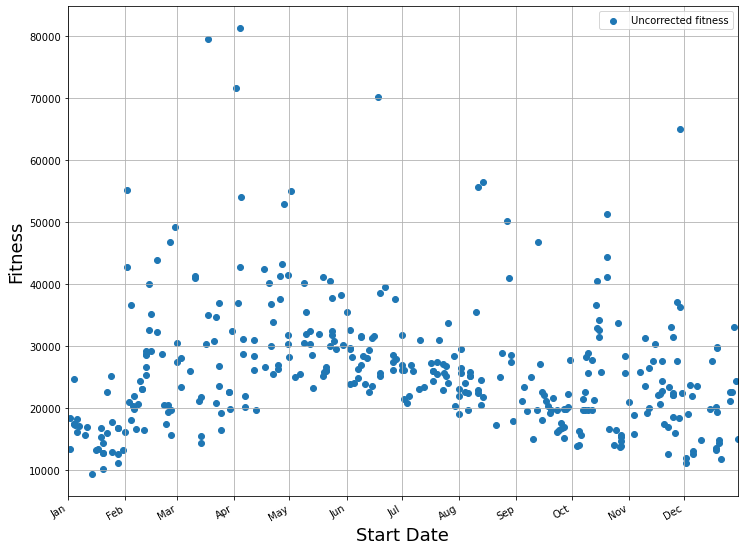

In [15]:
# Plot start_date vs fitness
fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(data.start_date, data.fitness, label='Uncorrected fitness')
format_plot('Start Date', 'Fitness')
ax.legend()
# fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/FitnessvStartDate.pdf'
# plt.savefig(fig_path, transparent=True, bbox_inches='tight')

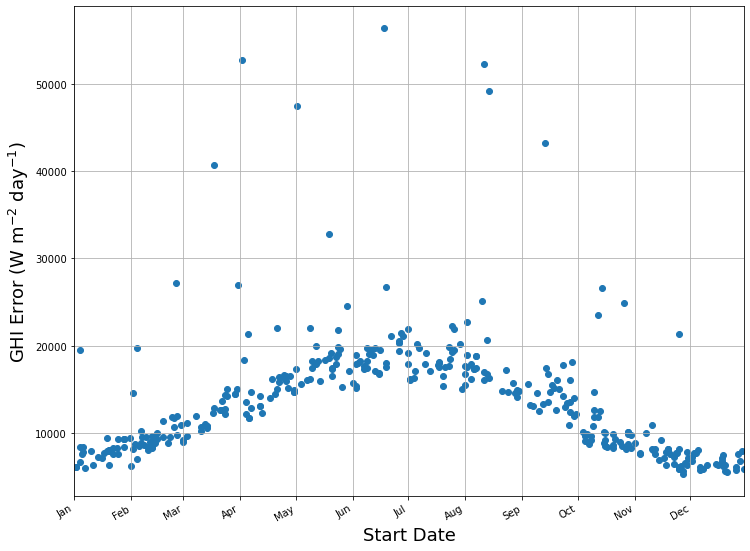

In [17]:
# Plot start_date vs ghi_error
fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(data.start_date, data.ghi_error)
format_plot('Start Date', 'GHI Error (W m$^{-2}$ day$^{-1}$)')
# ax.legend()

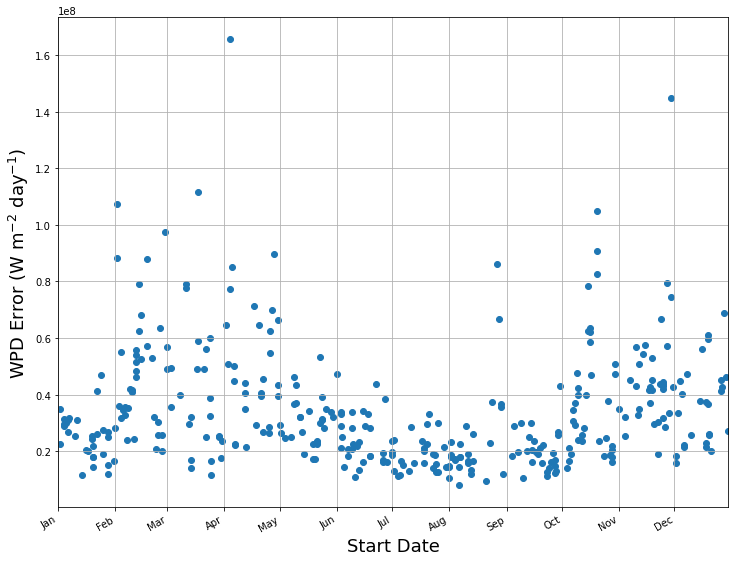

In [19]:
# Plot start_date vs ghi_error
fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(data.start_date, data.wpd_error)
format_plot('Start Date', 'WPD Error (W m$^{-2}$ day$^{-1}$)')

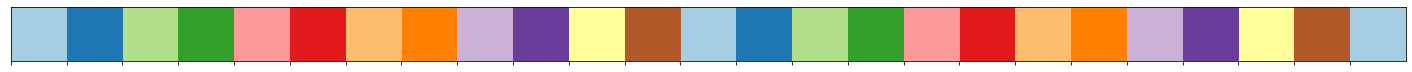

In [20]:
cmap1 = sns.color_palette('Paired', 25)
sns.palplot(cmap1)

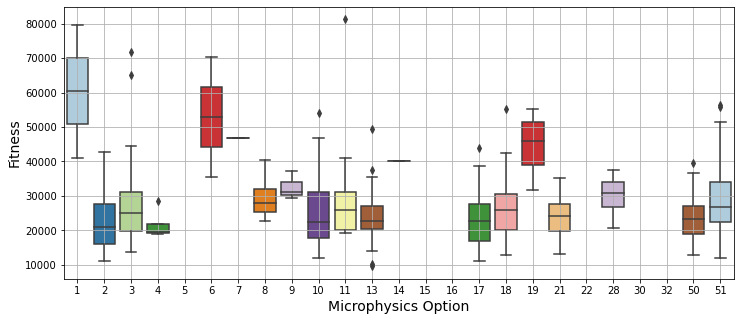

In [21]:
# Plot microphysics option vs. fitness
fig, ax = plt.subplots(figsize=(12, 5))
# sns.catplot(x='mp_physics', y='fitness', data=data, palette=cmap1)
# sns.boxplot(x='mp_physics', y='fitness', data=data, palette='Greys')
sns.boxplot(x='mp_physics', y='fitness', data=data, palette=cmap1)

plt.xlabel('Microphysics Option', fontsize=18)
plt.ylabel('Fitness', fontsize=18)
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)
ax.grid(True)
# fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/Fitnessvmp.pdf'
# plt.savefig(fig_path, transparent=True, bbox_inches='tight')

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


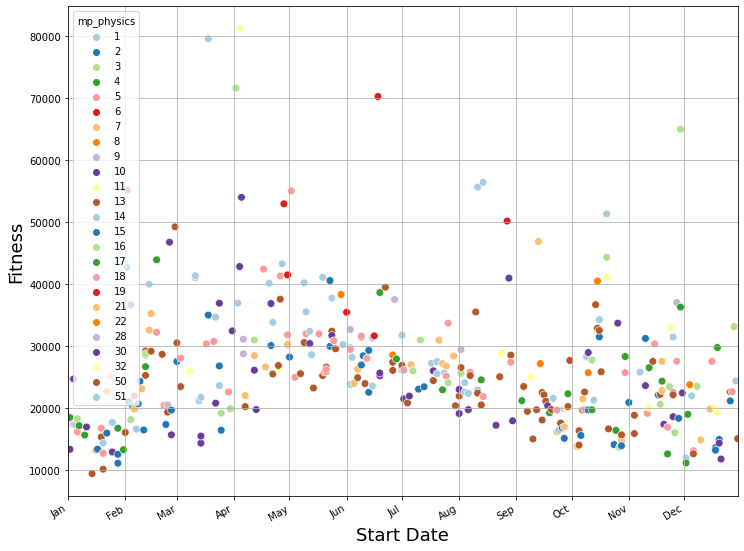

In [22]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(data.start_date, data.fitness, hue=data.mp_physics, legend='full', palette=cmap1, s=60)
format_plot('Start Date', 'Fitness')
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/FitnessvStartDate_mp.pdf'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

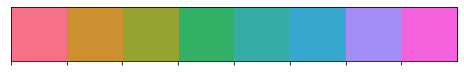

In [23]:
cmap2 = sns.husl_palette(8)
sns.palplot(cmap2)

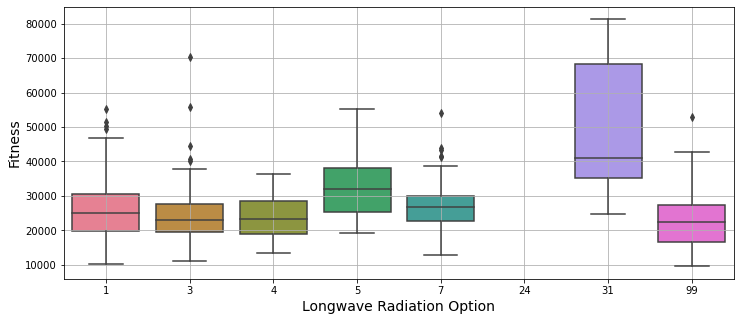

In [24]:
# Plot longwave radiation option vs. fitness
fig, ax = plt.subplots(figsize=(12, 5))
# sns.catplot(x='ra_lw_physics', y='fitness', data=data, palette=cmap2)
# sns.boxplot(x='ra_lw_physics', y='fitness', data=data, palette='Greys')
sns.boxplot(x='ra_lw_physics', y='fitness', data=data, palette=cmap2)
plt.xlabel('Longwave Radiation Option', fontsize=18)
plt.ylabel('Fitness', fontsize=18)
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)
ax.grid(True)
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/Fitnessvralw.pdf'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


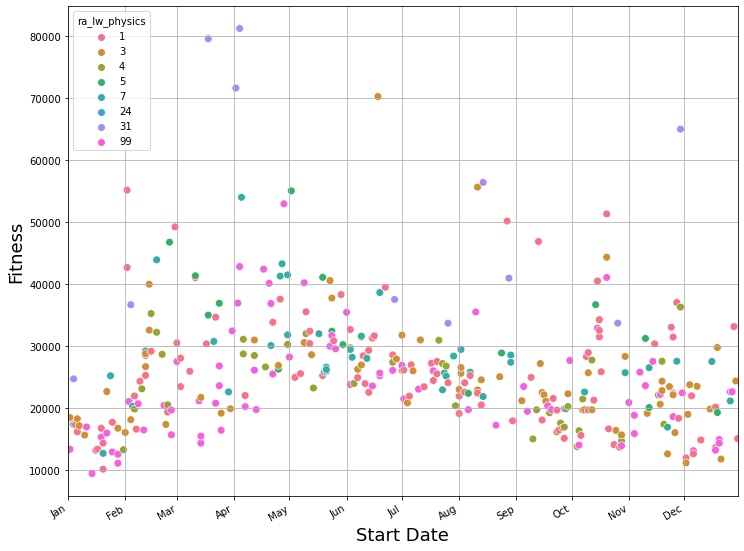

In [25]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(data.start_date, data.fitness, hue=data.ra_lw_physics, legend="full", palette=cmap2, s=60)
format_plot('Start Date', 'Fitness')
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/FitnessvStartDate_ralw.pdf'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

In [26]:
# Paired; n = 8; desat = 0.60
cmap3 = sns.choose_colorbrewer_palette('qualitative')

interactive(children=(Dropdown(description='name', options=('Set1', 'Set2', 'Set3', 'Paired', 'Accent', 'Paste…

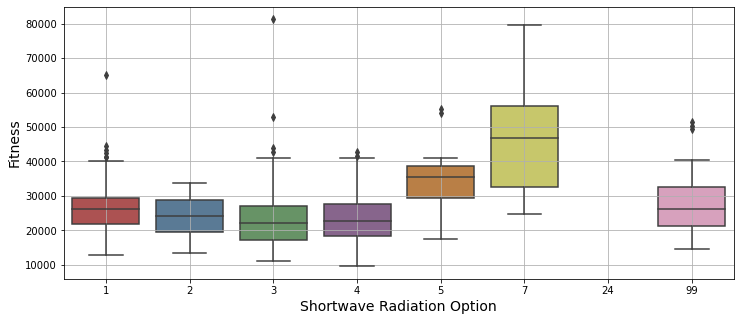

In [45]:
# Plot shortwave radiaiton option vs. fitness
fig, ax = plt.subplots(figsize=(12, 5))
# sns.catplot(x='ra_sw_physics', y='fitness', data=data, palette=cmap3)
# sns.boxplot(x='ra_sw_physics', y='fitness', data=data, palette='Greys')
sns.boxplot(x='ra_sw_physics', y='fitness', data=data, palette=cmap3)
plt.xlabel('Shortwave Radiation Option', fontsize=18)
plt.ylabel('Fitness', fontsize=18)
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)
ax.grid(True)
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/Fitnessvrasw.pdf'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


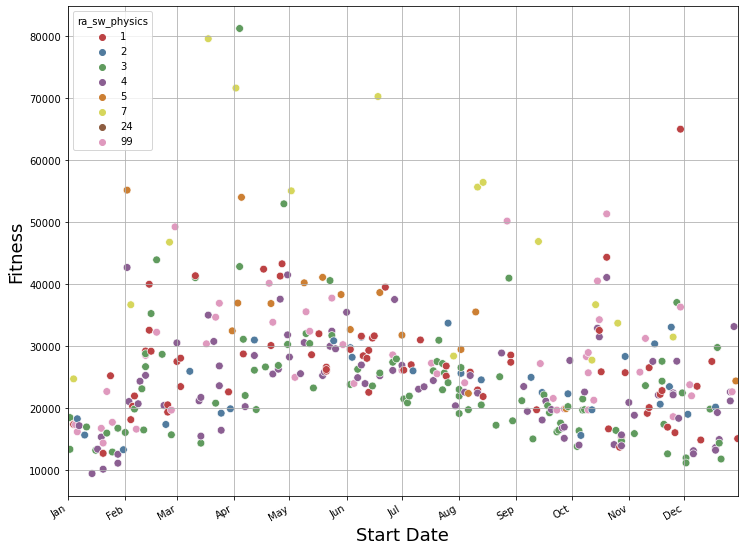

In [46]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(data.start_date, data.fitness, hue=data.ra_sw_physics, legend="full", palette=cmap3, s=60)
format_plot('Start Date', 'Fitness')
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/FitnessvStartDate_rasw.pdf'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

In [32]:
# Set2; n = 6; desat = 0.80
cmap4 = sns.choose_colorbrewer_palette('qualitative')

interactive(children=(Dropdown(description='name', options=('Set1', 'Set2', 'Set3', 'Paired', 'Accent', 'Paste…

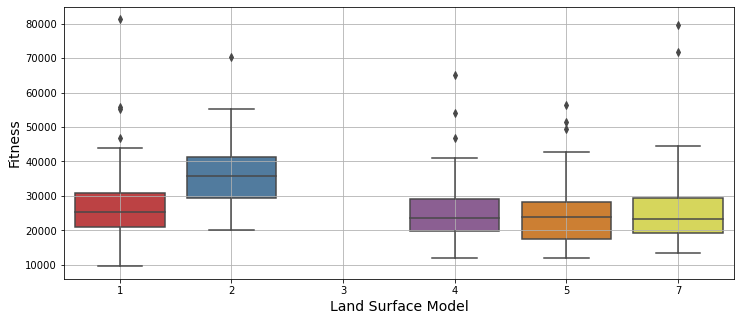

In [39]:
# Plot surface physics option vs. fitness
fig, ax = plt.subplots(figsize=(12, 5))
# sns.catplot(x='sf_surface_physics', y='fitness', data=data, palette=cmap4)
# sns.boxplot(x='sf_surface_physics', y='fitness', data=data, palette='Greys')
sns.boxplot(x='sf_surface_physics', y='fitness', data=data, palette=cmap4)
plt.xlabel('Land Surface Model', fontsize=18)
plt.ylabel('Fitness', fontsize=18)
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)
ax.grid(True)
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/Fitnessvlsm.pdf'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


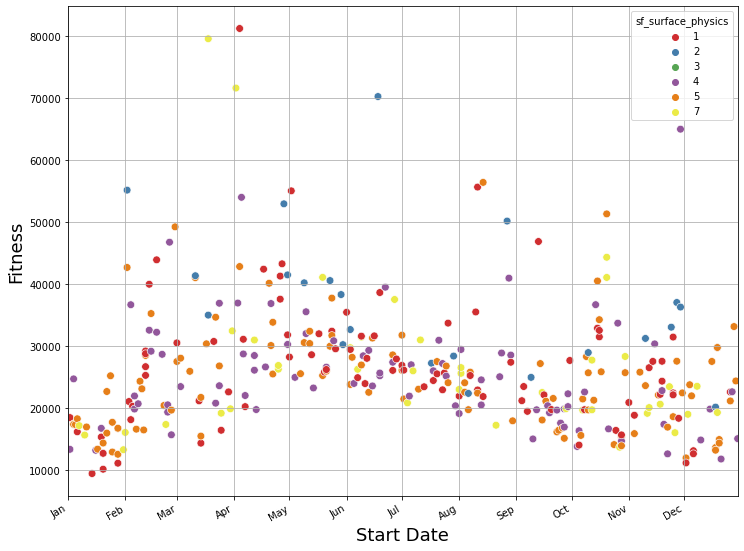

In [47]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(data.start_date, data.fitness, hue=data.sf_surface_physics, legend="full", palette=cmap4, s=60)
format_plot('Start Date', 'Fitness')
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/FitnessvStartDate_lsm.png'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

In [41]:
# Accent; n = 11; desat = 0.70
cmap5 = sns.choose_colorbrewer_palette('qualitative')

interactive(children=(Dropdown(description='name', options=('Set1', 'Set2', 'Set3', 'Paired', 'Accent', 'Paste…

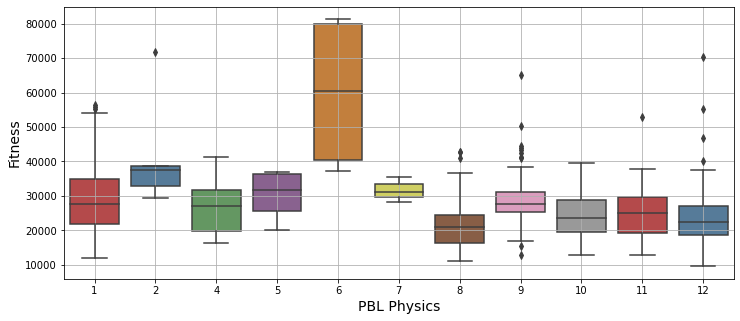

In [42]:
# Plot planetary boundary layer option vs. fitness
fig, ax = plt.subplots(figsize=(12, 5))
# sns.catplot(x='bl_pbl_physics', y='fitness', data=data, palette=cmap5)
# sns.boxplot(x='bl_pbl_physics', y='fitness', data=data, palette='Greys')
sns.boxplot(x='bl_pbl_physics', y='fitness', data=data, palette=cmap5)
plt.xlabel('PBL Physics', fontsize=18)
plt.ylabel('Fitness', fontsize=18)
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)
ax.grid(True)
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/Fitnessvpbl.pdf'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


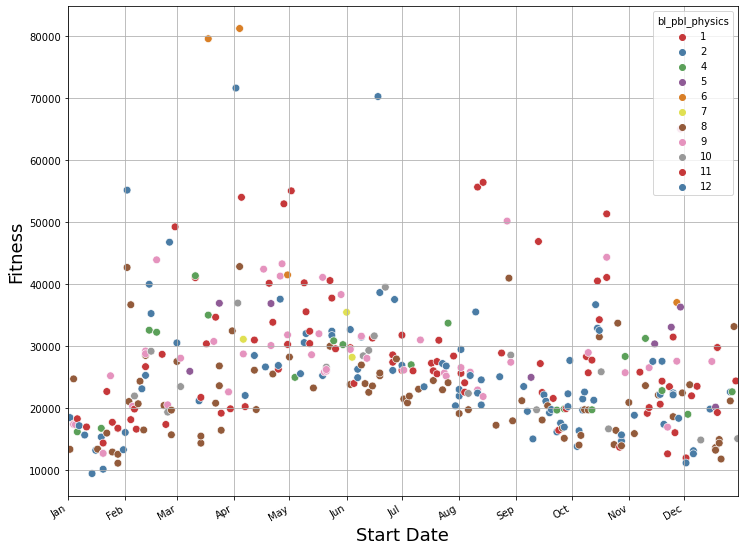

In [48]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(data.start_date, data.fitness, hue=data.bl_pbl_physics, legend="full", palette=cmap5, s=60)
format_plot('Start Date', 'Fitness')
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/FitnessvStartDate_pbl.pdf'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

In [49]:
# Dark2; n = 14; desat = 0.9
cmap6 = sns.choose_colorbrewer_palette('qualitative')

interactive(children=(Dropdown(description='name', options=('Set1', 'Set2', 'Set3', 'Paired', 'Accent', 'Paste…

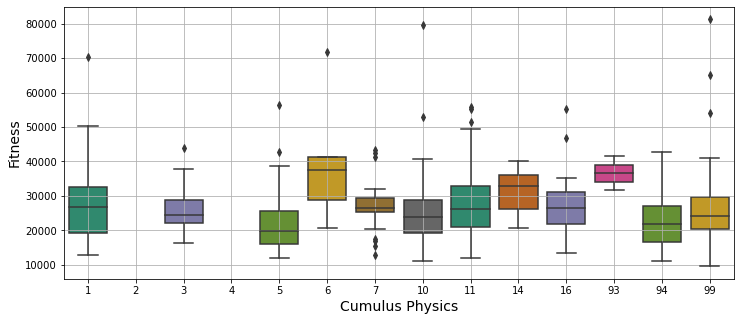

In [50]:
# Plot cumulus option vs. fitness
fig, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(x='cu_physics', y='fitness', data=data, palette=cmap6)
plt.xlabel('Cumulus Physics', fontsize=18)
plt.ylabel('Fitness', fontsize=18)
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)
ax.grid(True)
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/Fitnessvcu.pdf'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


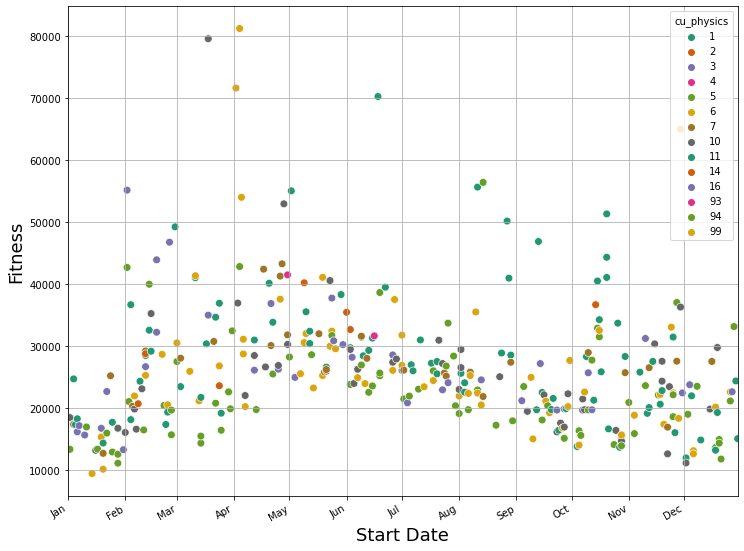

In [51]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(data.start_date, data.fitness, hue=data.cu_physics, legend="full", palette=cmap6, s=60)
format_plot('Start Date', 'Fitness')
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/FitnessvStartDate_cu.pdf'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

In [52]:
# Set1; n = 5; desat = 1.00
cmap7 = sns.choose_colorbrewer_palette('qualitative')

interactive(children=(Dropdown(description='name', options=('Set1', 'Set2', 'Set3', 'Paired', 'Accent', 'Paste…

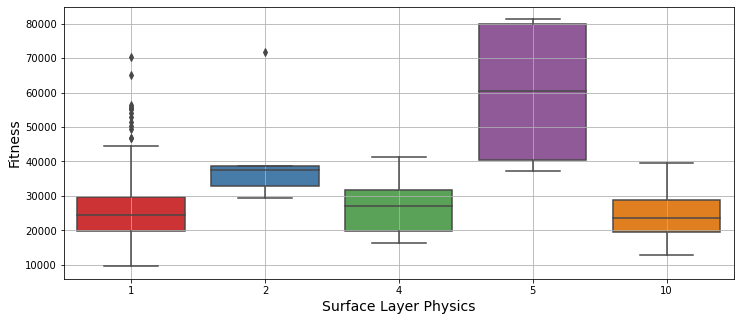

In [53]:
# Plot surface layer option vs. Fitness
fig, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(x='sf_sfclay_physics', y='fitness', data=data, palette=cmap7)
plt.xlabel('Surface Layer Physics', fontsize=18)
plt.ylabel('Fitness', fontsize=18)
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)
ax.grid(True)
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/Fitnessvsfclay.pdf'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


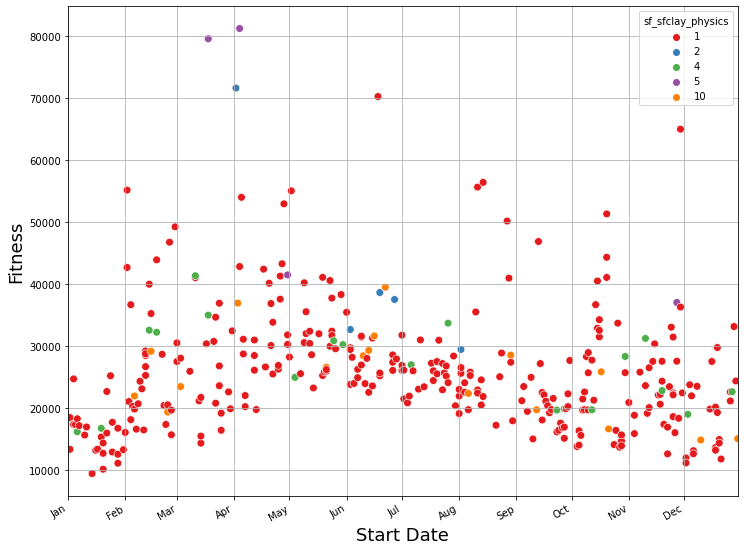

In [54]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(data.start_date, data.fitness, hue=data.sf_sfclay_physics, legend="full", palette=cmap7, s=60)
format_plot('Start Date', 'Fitness')
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/FitnessvStartDate_sfclay.pdf'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

Text(0, 0.5, 'Fitness')

Glyph 9 missing from current font.
Glyph 9 missing from current font.


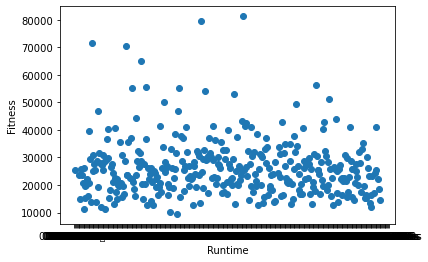

In [57]:
# Plot runtime vs fitness
data = data.sort_values(by='runtime')

fig, ax = plt.subplots()
plt.scatter(data.runtime, data.fitness)
plt.xlabel('Runtime')
plt.ylabel('Fitness')

## Heatmap showing the overall correlation matrix

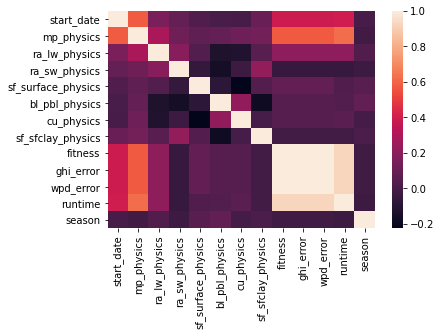

In [56]:
# Plot an overall heatmap
corr_matrix = data.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
sns.heatmap(corr_matrix)
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/Heatmap_overall.pdf'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')